In [82]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
from src.data_processing import process_file, compute_physical, process_file_from_wizard, split_experiments
import numpy as np
from scipy.integrate import odeint
import matplotlib as mpl

# Set the font size globally
mpl.rcParams.update({'font.size': 13})  # Change 14 to your desired font size


folder_path = "data/exp15_02/*.csv"
folder_path = "data/exp15_02/without_J_ext/*.csv"
# folder_path = "data/exp15_02/with_J_ext/*.csv"
folder_path = "data/exp15_02/without_J_ext_2/*.csv"

# List to store each processed dataframe
processed_dataframes = []

# Iterate over all CSV files in the folder
for file_path in glob.glob(folder_path):
    # Apply processing function to the dataframe
    processed_df = process_file_from_wizard(file_path)

    # processed_df = split_experiments(processed_df)
    
    # Store the processed dataframe in the list
    processed_dataframes.append(processed_df)

external_inertia = 0.0022421143208 # Msolo
# external_inertia = 0
Ra = 9.3756 # [Ohm]
kt = 2.6657
ke = 3.6103
U_a = 12

# (0.12834928717151478, 0.22012086337018552, 0.0730515032605435) on test 2
tau_c = 0.12834928717151478
c_v = 0.22012086337018552
J = 0.0730515032605435 + external_inertia
tau_c = 0.14628898896564263
c_v = 0.20278725799569575
J = 0.0720357539855984 + external_inertia
len(processed_dataframes)

10

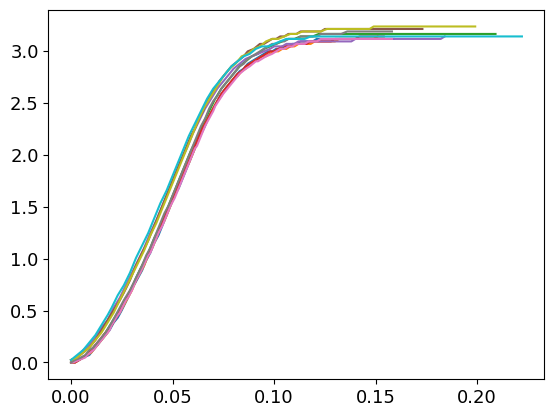

In [83]:
def find_indices_of_start(df):
    indices_of_change = []
    for i in range(len(df) - 1):
        if df['U'].iloc[i] == 0 and df['U'].iloc[i + 1] != 0:
            indices_of_change.append(i)
    return indices_of_change

df_starting = []
for df in processed_dataframes:
    index = find_indices_of_start(df)[0]
    df = df[index+4:index+80].reset_index(drop=True)
    # df = df[(df['U'] == 0) & (df['U'].shift(1) != 0)][:].reset_index(drop=True)
    plt.plot(df['t']-df['t'].iloc[0], abs(df['DXL_Velocity']))
    df_starting.append(df)


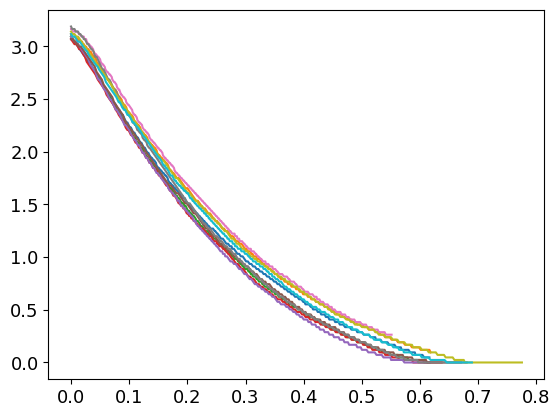

In [84]:
def find_indices_of_end(df):
    indices_of_change = []
    for i in range(len(df) - 1):
        if df['U'].iloc[i] == 0 and df['U'].iloc[i - 1] != 0:
            indices_of_change.append(i)
    return indices_of_change

df_ending = []
for df in processed_dataframes:
    index = find_indices_of_end(df)[0]
    df = df[index+15:index+290].reset_index(drop=True)
    # df = df[(df['U'] == 0) & (df['U'].shift(1) != 0)][:].reset_index(drop=True)
    plt.plot(df['t']-df['t'].iloc[0], abs(df['DXL_Velocity']))
    df_ending.append(df)

3.176515598986314

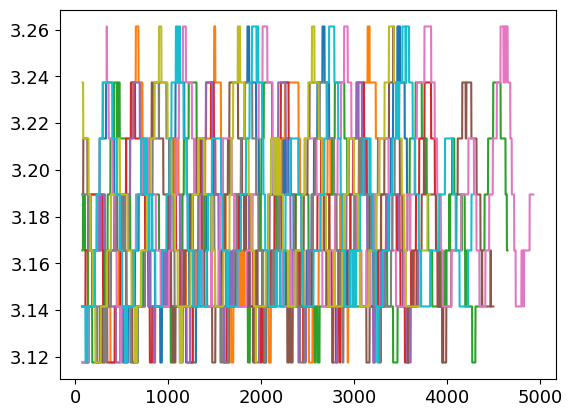

In [85]:
v_f = []
for df in processed_dataframes:
    df = df[:]
    # df = df[df['U'] != 0][:100].reset_index(drop=True)
    # plt.plot(df['t']-df['t'].iloc[0], abs(df['DXL_Velocity']))
    df = df[df['U'] != 0].reset_index(drop=True)

    plt.plot(abs(df['DXL_Velocity'][80:]))
    v_f.append(abs(df['DXL_Velocity'][80:].mean()))

import statistics
statistics.mean(v_f)

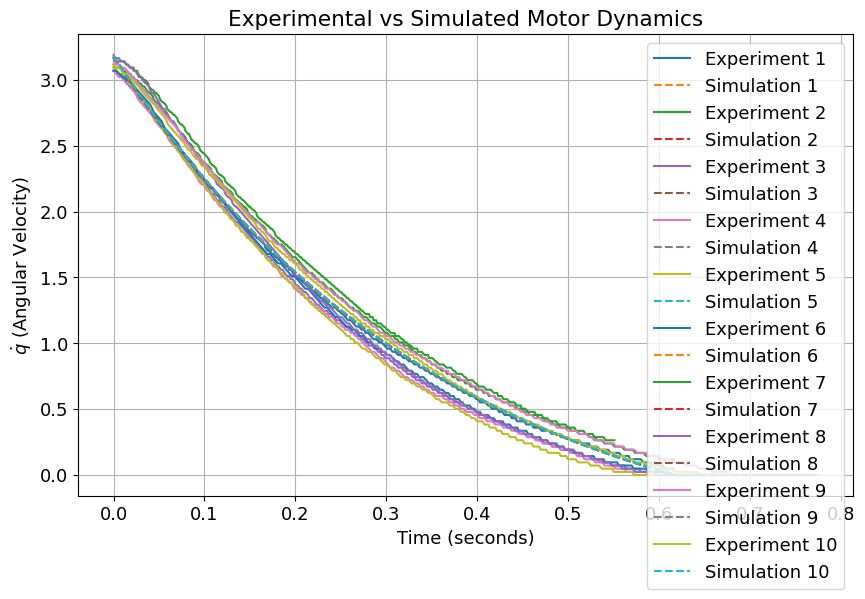

In [86]:
def motor_dynamics_updated(q_dot, t, tau_c, c_v, J):
    if q_dot <= 0:
        return 0
    else :
        return (-tau_c - c_v * q_dot) / J

# Initialize arrays for all experimental data
all_t = np.array([])
all_velocity = np.array([])

# Placeholder for plotting the simulated data along with the experimental data
fig, ax = plt.subplots(figsize=(10, 6))

# Process each dataframe in the list and simulate the corresponding response
for count, df in enumerate(df_ending):
    # Initial velocity for the current experiment
    q_dot_0 = v_f[count]
    
    # Extract time and velocity from the current experiment
    t_exp = df['t'] - df['t'].iloc[0]
    velocity_exp = abs(df['DXL_Velocity'].reset_index(drop=True))
    
    # Combine the data from this experiment with the overall data
    all_t = np.concatenate((all_t, t_exp))
    all_velocity = np.concatenate((all_velocity, velocity_exp))
    
    # Plot the experimental data
    ax.plot(t_exp, velocity_exp, label=f'Experiment {count+1}')
    
    # Simulate the deceleration phase for the current experiment
    t_sim = np.linspace(0, t_exp.iloc[-1], len(t_exp))
    q_dot_simulated = odeint(motor_dynamics_updated, q_dot_0, t_sim, args=(tau_c, c_v, J)).flatten()
    
    # Plot the simulated data
    ax.plot(t_sim, q_dot_simulated, label=f'Simulation {count+1}', linestyle='--')

# Enhance the plot
ax.set_title('Experimental vs Simulated Motor Dynamics')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel(r'$\dot{q}$ (Angular Velocity)')
ax.legend()
ax.grid(True)

plt.show()


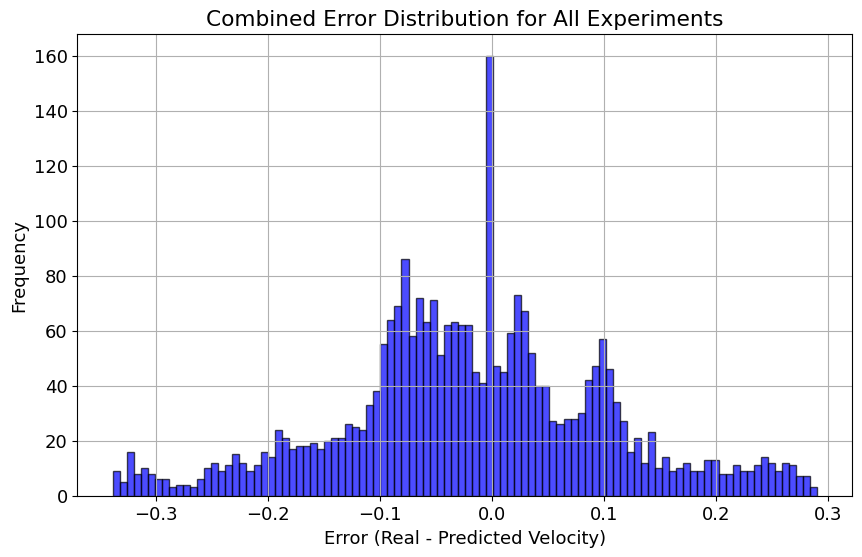

In [91]:
# Placeholder code for calculating and plotting the combined error distribution for all experiments

# Initialize arrays to hold all errors
all_errors = np.array([])

# Process each dataframe in the list and calculate the error distribution
for count, df in enumerate(df_ending):
    # Initial velocity for the current experiment
    q_dot_0 = v_f[count]
    
    # Extract time and velocity from the current experiment
    t_exp = df['t'] - df['t'].iloc[0]
    velocity_exp = abs(df['DXL_Velocity'].reset_index(drop=True))
    
    # Simulate the deceleration phase for the current experiment
    t_sim = np.linspace(0, t_exp.iloc[-1], len(t_exp))
    q_dot_simulated = odeint(motor_dynamics_updated, q_dot_0, t_sim, args=(tau_c, c_v, J)).flatten()
    
    # Calculate the error (experimental - simulated)
    error = (velocity_exp - q_dot_simulated)
    
    # Combine the errors from this experiment with the overall error array
    all_errors = np.concatenate((all_errors, error))

# Plot the combined error distribution
plt.figure(figsize=(10, 6))
plt.hist(all_errors, bins=100, color='blue', edgecolor='black', alpha=0.7)
plt.title('Combined Error Distribution for All Experiments')
plt.xlabel('Error (Real - Predicted Velocity)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


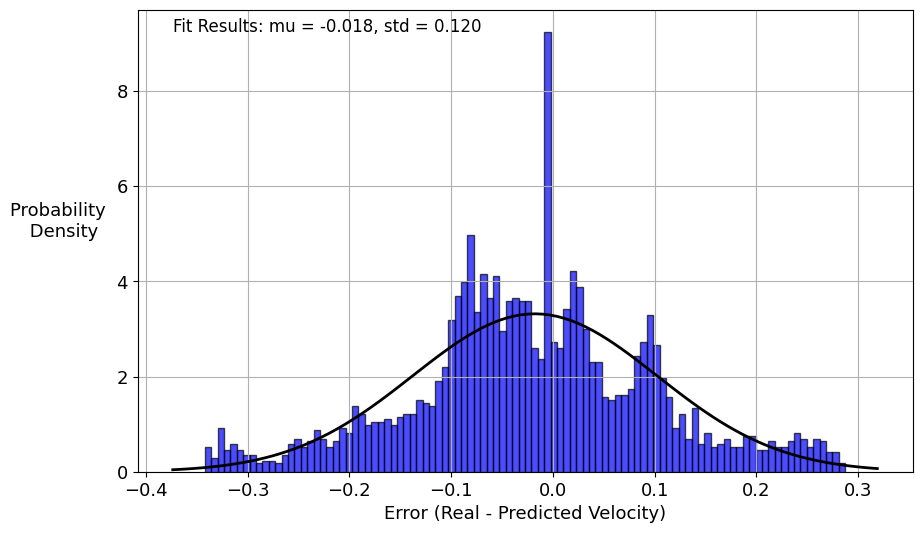

In [92]:

# Calculate histogram data
counts, bin_edges = np.histogram(all_errors, bins=100, density=True)
bin_width = bin_edges[1] - bin_edges[0]

# Convert counts to probabilities
probabilities = counts / counts.sum()

# Fit a normal distribution to the data
mu, std = norm.fit(all_errors)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], counts, width=bin_width, color='blue', edgecolor='black', alpha=0.7)

# Plot the PDF of the fitted normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Add title and labels to the plot
# plt.title('Error Distribution for Experiments with external load with Normal Fit')
plt.xlabel('Error (Real - Predicted Velocity)')
plt.ylabel('Probability \n Density', rotation=0, labelpad=40)

# Show the fit parameters on the plot
plt.text(xmin, max(counts), f'Fit Results: mu = {mu:.3f}, std = {std:.3f}', fontsize=12)

plt.grid(True)
plt.show()

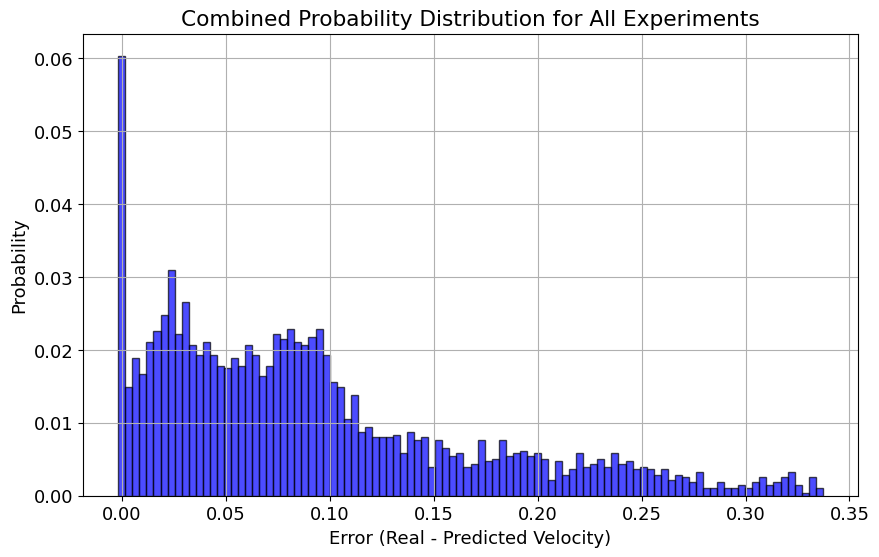

In [89]:
# Assuming 'all_errors' is an array containing the error data

# Calculate histogram data
counts, bin_edges = np.histogram(all_errors, bins=100, density=False)
bin_width = bin_edges[1] - bin_edges[0]

# Convert counts to probabilities
probabilities = counts / counts.sum()

# Plot the histogram as probabilities
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], probabilities, width=bin_width, color='blue', edgecolor='black', alpha=0.7)
plt.title('Combined Probability Distribution for All Experiments')
plt.xlabel('Error (Real - Predicted Velocity)')
plt.ylabel('Probability')
plt.grid(True)
plt.show()


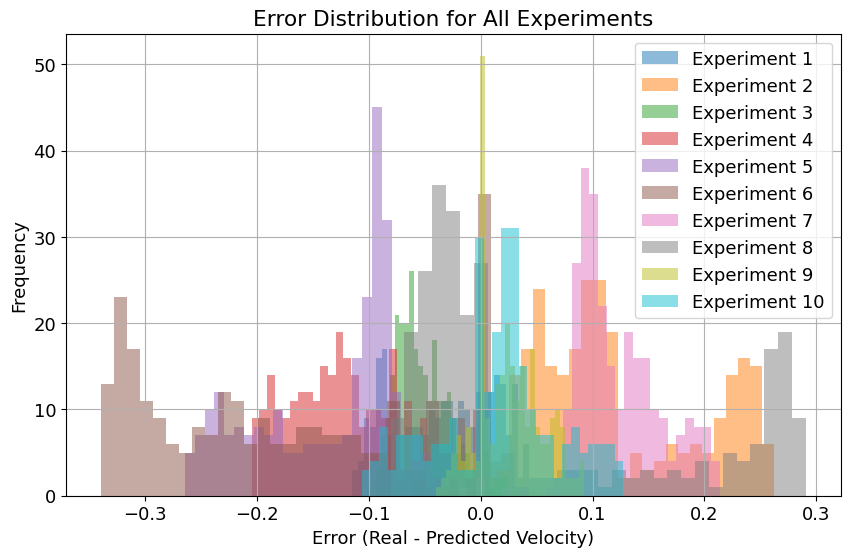

In [90]:
# Initialize a figure for the error distribution plot
fig, ax = plt.subplots(figsize=(10, 6))

# Process each dataframe in the list and calculate the error distribution
for count, df in enumerate(df_ending):
    # Initial velocity for the current experiment
    q_dot_0 = v_f[count]
    
    # Extract time and velocity from the current experiment
    t_exp = df['t'] - df['t'].iloc[0]
    velocity_exp = abs(df['DXL_Velocity'].reset_index(drop=True))
    
    # Simulate the deceleration phase for the current experiment
    t_sim = np.linspace(0, t_exp.iloc[-1], len(t_exp))
    q_dot_simulated = odeint(motor_dynamics_updated, q_dot_0, t_sim, args=(tau_c, c_v, J)).flatten()
    
    # Calculate the error (experimental - simulated)
    error = velocity_exp - q_dot_simulated
    
    # Plot the error distribution for the current experiment
    ax.hist(error, bins=30, alpha=0.5, label=f'Experiment {count+1}')

# Enhance the plot
ax.set_title('Error Distribution for All Experiments')
ax.set_xlabel('Error (Real - Predicted Velocity)')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(True)

# Show the plot
plt.show()
